### How to use this notebook
The data used in this notebook is not public. Contact Tamas to get an API key. Then create a python file in the same folder as this notebook, and name that file *girder_apikey_read.py*. Add only one line to that file that looks like this, just a different key string:
`girder_apikey_read="UjNzqutrfBwuk4t39VlJnJs4t3EZ6i7"`

In [1]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

this_notebook_name = "ResUNet-BreastTumorSegmentationStudy"

# This should be the only parameter to update for your local environment

local_data_folder = r"/home/justin/Desktop/BreastTumorSegmentationStudy"
overwrite_existing_data_files = False

# All results and output will be archived with this timestamp

import datetime
save_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print("Save timestamp: {}".format(save_timestamp))

import numpy as np
ultrasound_size = 128
num_classes = 2
num_epochs = 100
batch_size = 32
max_learning_rate = 0.02
min_learning_rate = 0.00001
regularization_rate = 0.0001
filter_multiplier = 8
class_weights = np.array([0.1, 0.9])
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Training data augmentation parameters

max_shift_factor = 0.12
max_rotation_angle = 10
max_zoom_factor = 1.1
min_zoom_factor = 0.8

# Evaluation parameters

acceptable_margin_mm = 3.0
mm_per_pixel = 1.0

roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001]
limit_validation_rounds = 12


# limit_validation_rounds = 1

Save timestamp: 2020-01-29_10-50-57


In [2]:
import os
from random import sample

from ipywidgets import IntProgress
from IPython.display import display, HTML

import girder_client
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.backend import clear_session
""
import ultrasound_batch_generator as generator
import sagittal_spine_segmentation_unet as unet
import ResUNet_Model as resunet
import evaluation_metrics


from girder_apikey_read import girder_apikey_read

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [4]:

girder_api_url = "https://pocus.cs.queensu.ca/api/v1"

training_ultrasound_ids = [
    "5e1bae9ed9e6a3be02d013bc", #003
    "5dfbc687d9e6a3be02d01343", #004-v02
    "5e1cb476d9e6a3be02d01425", #005-v02
    
    "5e1cb84ed9e6a3be02d0143a", #007-v02
    "5e14cef4d9e6a3be02d01377", #008-v02
    "5e14cef4d9e6a3be02d0137a", #009-v02
    #"5e1cba04d9e6a3be02d01440", #010-v02
    "5e1cbd21d9e6a3be02d01446", #011
    
    "5e1cc395d9e6a3be02d01452", #013
    "5e1cc4fcd9e6a3be02d01458", #014
    "5e14cef4d9e6a3be02d0137d", #015
    "5e1cc907d9e6a3be02d0145e", #016
    
    "5e1ccb5dd9e6a3be02d0146a", #019
    "5e1cb5ced9e6a3be02d0142b", #020
    "5e16028cd9e6a3be02d01386", #021
    "5e163f18d9e6a3be02d01392", #022
    "5e163f0dd9e6a3be02d0138c", #023
   
    "5e163f2ad9e6a3be02d0139e", #025
    "5e1c99f1d9e6a3be02d01401", #026
    "5e1c99f1d9e6a3be02d01404", #027
    "5e1c99f2d9e6a3be02d01407", #028
    "5e1c99f2d9e6a3be02d0140a", #029
    
    "5e1c99f3d9e6a3be02d01410", #031
    "5e1c99f4d9e6a3be02d01413", #032
    "5e1c99f5d9e6a3be02d01416", #035
    "5e1c99f5d9e6a3be02d01419", #037
    "5e1c99f6d9e6a3be02d0141c", #038
    "5e1c99f6d9e6a3be02d0141f", #039
]


training_ultrasound_filenames = [
    "ultrasound-003-v02.npy",
    "ultrasound-004-v02.npy",
    "ultrasound-005-v02.npy",
    
    "ultrasound-007-v02.npy",
    "ultrasound-008-v02.npy",
    "ultrasound-009-v02.npy",
    #"ultrasound-010-v02.npy",
    "ultrasound-011.npy",
    
    "ultrasound-013.npy",
    "ultrasound-014.npy",
    "ultrasound-015.npy",
    "ultrasound-016.npy",
    
    "ultrasound-019.npy",
    "ultrasound-020.npy",
    "ultrasound-021.npy",
    "ultrasound-022.npy",
    "ultrasound-023.npy",
    
    "ultrasound-025.npy",
    "ultrasound-026.npy",
    "ultrasound-027.npy",
    "ultrasound-028.npy",
    "ultrasound-029.npy",
    
    "ultrasound-031.npy",
    "ultrasound-032.npy",
    "ultrasound-035.npy",
    "ultrasound-037.npy",
    "ultrasound-038.npy",
    "ultrasound-039.npy"
]

testing_ultrasound__ids = [
    "5e1cb685d9e6a3be02d01434", #006-v02
    "5e1cbf54d9e6a3be02d0144c", #012
    "5e1cca85d9e6a3be02d01464", #018
    "5e163f22d9e6a3be02d01398", #024
    "5e1c99f3d9e6a3be02d0140d", #030
]

testing_ultrasound_filenames = [
    "ultrasound-006-v02.npy",
    "ultrasound-012.npy",
    "ultrasound-018.npy",
    "ultrasound-024.npy",
    "ultrasound-030.npy",
]

training_segmentation_ids = [
    "5e1bae9ed9e6a3be02d013b9", #003
    "5dfbc686d9e6a3be02d01340", #004-v02
    "5e1cb475d9e6a3be02d01422", #005-v02
    
    "5e1cb84dd9e6a3be02d01437", #007-v02
    "5e14cef3d9e6a3be02d0136e", #008-v02
    "5e14cef3d9e6a3be02d01371", #009-v02
    #"5e1cba04d9e6a3be02d0143d", #010-v02
    "5e1cbd20d9e6a3be02d01443", #011
    
    "5e1cc395d9e6a3be02d0144f", #013
    "5e1cc4fcd9e6a3be02d01455", #014
    "5e14cef3d9e6a3be02d01374", #015
    "5e1cc906d9e6a3be02d0145b", #016
    
    "5e1ccb5cd9e6a3be02d01467", #019
    "5e1cb5ced9e6a3be02d01428", #020
    "5e16028bd9e6a3be02d01383", #021
    "5e163f17d9e6a3be02d0138f", #022
    "5e163f0cd9e6a3be02d01389", #023
    
    "5e163f29d9e6a3be02d0139b", #025
    "5e1c99edd9e6a3be02d013e0", #026
    "5e1c99edd9e6a3be02d013e3", #027
    "5e1c99edd9e6a3be02d013e6", #028
    "5e1c99eed9e6a3be02d013e9", #029
    
    "5e1c99eed9e6a3be02d013ef", #031
    "5e1c99efd9e6a3be02d013f2", #032
    "5e1c99efd9e6a3be02d013f5", #035
    "5e1c99efd9e6a3be02d013f8", #037
    "5e1c99efd9e6a3be02d013fb", #038
    "5e1c99f0d9e6a3be02d013fe" #039 
]

training_segmentation_filenames = [
    "segmentation-003-v02.npy",
    "segmentation-004-v02.npy",
    "segmentation-005-v02.npy",
    
    "segmentation-007-v02.npy",
    "segmentation-008-v02.npy",
    "segmentation-009-v02.npy",
    #"segmentation-010-v02.npy",
    "segmentation-011.npy",
    
    "segmentation-013.npy",
    "segmentation-014.npy",
    "segmentation-015.npy",
    "segmentation-016.npy",
    
    "segmentation-019.npy",
    "segmentation-020.npy",
    "segmentation-021.npy",
    "segmentation-022.npy",
    "segmentation-023.npy",
    
    "segmentation-025.npy",
    "segmentation-026.npy",
    "segmentation-027.npy",
    "segmentation-028.npy",
    "segmentation-029.npy",
    
    "segmentation-031.npy",
    "segmentation-032.npy",
    "segmentation-035.npy",
    "segmentation-037.npy",
    "segmentation-038.npy",
    "segmentation-039.npy"
]

testing_segmentation_ids = [
    "5e1cb684d9e6a3be02d01431", #006-v02
    "5e1cbf54d9e6a3be02d01449", #012
    "5e1cca84d9e6a3be02d01461", #018
    "5e163f21d9e6a3be02d01395", #024
    "5e1c99eed9e6a3be02d013ec", #030
]

testing_segmentation_filenames = [
    "segmentation-006-v02.npy",
    "segmentation-012.npy",
    "segmentation-018.npy",
    "segmentation-024.npy",
    "segmentation-030.npy",
]

In [5]:
# These subfolders will be created/populated in the data folder

data_arrays_folder    = "DataArrays"
notebooks_save_folder = "SavedNotebooks"
results_save_folder   = "SavedResults"
models_save_folder    = "SavedModels"
val_data_folder       = "PredictionsValidation"

data_arrays_fullpath = os.path.join(local_data_folder, data_arrays_folder)
notebooks_save_fullpath = os.path.join(local_data_folder, notebooks_save_folder)
results_save_fullpath = os.path.join(local_data_folder, results_save_folder)
models_save_fullpath = os.path.join(local_data_folder, models_save_folder)
val_data_fullpath = os.path.join(local_data_folder, val_data_folder)

if not os.path.exists(data_arrays_fullpath):
    os.makedirs(data_arrays_fullpath)
    print("Created folder: {}".format(data_arrays_fullpath))

if not os.path.exists(notebooks_save_fullpath):
    os.makedirs(notebooks_save_fullpath)
    print("Created folder: {}".format(notebooks_save_fullpath))

if not os.path.exists(results_save_fullpath):
    os.makedirs(results_save_fullpath)
    print("Created folder: {}".format(results_save_fullpath))

if not os.path.exists(models_save_fullpath):
    os.makedirs(models_save_fullpath)
    print("Created folder: {}".format(models_save_fullpath))

if not os.path.exists(val_data_fullpath):
    os.makedirs(val_data_fullpath)
    print("Created folder: {}".format(val_data_fullpath))

In [6]:
# Download data from Girder

time_download_start = datetime.datetime.now()

print("Downloading training files ...")

# Setting up number of validation rounds

n_files = len(training_ultrasound_ids)
if limit_validation_rounds > 0:
    num_validation_rounds = min(n_files, limit_validation_rounds)
else:
    num_validation_rounds = n_files

# Preparing progress bar

f = IntProgress(min=0, max=n_files*2)
display(f)

# Downloading files

gclient = girder_client.GirderClient(apiUrl=girder_api_url)
gclient.authenticate(apiKey=girder_apikey_read)

for i in range(n_files):
    ultrasound_fullname = os.path.join(data_arrays_fullpath, training_ultrasound_filenames[i])
    if not os.path.exists(ultrasound_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(ultrasound_fullname))
        gclient.downloadFile(training_ultrasound_ids[i], ultrasound_fullname)
    f.value = i * 2 + 1
    
    segmentation_fullname = os.path.join(data_arrays_fullpath, training_segmentation_filenames[i])
    if not os.path.exists(segmentation_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(segmentation_fullname))
        gclient.downloadFile(training_segmentation_ids[i], segmentation_fullname)
    f.value = i * 2 + 2

time_download_stop = datetime.datetime.now()
print("\nTotal download time: {}".format(time_download_stop - time_download_start))

IntProgress(value=0, max=54)


Total download time: 0:00:00.053042


In [7]:
# Read data into numpy arrays

ultrasound_arrays = []
segmentation_arrays = []

f = IntProgress(min=0, max=n_files * 2)
display(f)

time_start = datetime.datetime.now()

for i in range(n_files):
    ultrasound_fullname = os.path.join(data_arrays_fullpath, training_ultrasound_filenames[i])
    segmentation_fullname = os.path.join(data_arrays_fullpath, training_segmentation_filenames[i])

    ultrasound_data = np.load(ultrasound_fullname)
    f.value = i * 2 + 1
    
    segmentation_data = np.load(segmentation_fullname)
    f.value = i * 2 + 2
    
    ultrasound_arrays.append(ultrasound_data)
    segmentation_arrays.append(segmentation_data)

time_stop = datetime.datetime.now()
print("\nTotal time to load from files: {}".format(time_stop - time_start))

IntProgress(value=0, max=54)


Total time to load from files: 0:00:00.103219


Timestamp for saved files: 2020-01-29_10-50-57

Training parameters
Number of epochs:    100
Step size maximum:   0.02
Step size decay:     0.0001999
Batch size:          32
Regularization rate: 0.0001

Saving validation predictions in: /home/justin/Desktop/BreastTumorSegmentationStudy/PredictionsValidation
Saving models in:                 /home/justin/Desktop/BreastTumorSegmentationStudy/SavedModels

*** Leave-two-out round # 0

Training on 5189 images, validating on 671 images...
Validation ultrasound data shape:            (671, 128, 128, 1)
Validation segmentation data shape:          (671, 128, 128, 1)
Validation segmentation data (onehot) shape: (671, 128, 128, 2)
Epoch 1/100


/home/justin/anaconda3/envs/masters/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


162/162 [==============================] - 65s 400ms/step - loss: 0.0250 - accuracy: 0.9579 - dice_coef: 0.9740 - val_loss: 0.0110 - val_accuracy: 0.9839 - val_dice_coef: 0.9910
Epoch 2/100
162/162 [==============================] - 62s 382ms/step - loss: 0.0157 - accuracy: 0.9650 - dice_coef: 0.9820 - val_loss: 0.0464 - val_accuracy: 0.9883 - val_dice_coef: 0.9925
Epoch 3/100
162/162 [==============================] - 62s 382ms/step - loss: 0.0155 - accuracy: 0.9658 - dice_coef: 0.9820 - val_loss: 0.0092 - val_accuracy: 0.9865 - val_dice_coef: 0.9926
Epoch 4/100
162/162 [==============================] - 62s 381ms/step - loss: 0.0133 - accuracy: 0.9699 - dice_coef: 0.9844 - val_loss: 0.0163 - val_accuracy: 0.9488 - val_dice_coef: 0.9725
Epoch 5/100
162/162 [==============================] - 62s 382ms/step - loss: 0.0129 - accuracy: 0.9708 - dice_coef: 0.9848 - val_loss: 0.0091 - val_accuracy: 0.9914 - val_dice_coef: 0.9954
Epoch 6/100
162/162 [==============================] - 62s 382

162/162 [==============================] - 62s 382ms/step - loss: 0.0082 - accuracy: 0.9796 - dice_coef: 0.9895 - val_loss: 0.0051 - val_accuracy: 0.9887 - val_dice_coef: 0.9941
Epoch 45/100
162/162 [==============================] - 62s 381ms/step - loss: 0.0090 - accuracy: 0.9785 - dice_coef: 0.9889 - val_loss: 0.0093 - val_accuracy: 0.9845 - val_dice_coef: 0.9920
Epoch 46/100
162/162 [==============================] - 62s 381ms/step - loss: 0.0085 - accuracy: 0.9791 - dice_coef: 0.9892 - val_loss: 0.0066 - val_accuracy: 0.9925 - val_dice_coef: 0.9960
Epoch 47/100
162/162 [==============================] - 62s 382ms/step - loss: 0.0096 - accuracy: 0.9780 - dice_coef: 0.9884 - val_loss: 0.0056 - val_accuracy: 0.9901 - val_dice_coef: 0.9949
Epoch 48/100
162/162 [==============================] - 62s 381ms/step - loss: 0.0081 - accuracy: 0.9803 - dice_coef: 0.9897 - val_loss: 0.0059 - val_accuracy: 0.9919 - val_dice_coef: 0.9957
Epoch 49/100
162/162 [==============================] - 62

Epoch 87/100
162/162 [==============================] - 62s 380ms/step - loss: 0.0063 - accuracy: 0.9842 - dice_coef: 0.9916 - val_loss: 0.0059 - val_accuracy: 0.9914 - val_dice_coef: 0.9955
Epoch 88/100
162/162 [==============================] - 62s 381ms/step - loss: 0.0065 - accuracy: 0.9837 - dice_coef: 0.9914 - val_loss: 0.0078 - val_accuracy: 0.9925 - val_dice_coef: 0.9960
Epoch 89/100
162/162 [==============================] - 62s 381ms/step - loss: 0.0062 - accuracy: 0.9847 - dice_coef: 0.9918 - val_loss: 0.0085 - val_accuracy: 0.9941 - val_dice_coef: 0.9967
Epoch 90/100
162/162 [==============================] - 62s 381ms/step - loss: 0.0062 - accuracy: 0.9843 - dice_coef: 0.9917 - val_loss: 0.0070 - val_accuracy: 0.9921 - val_dice_coef: 0.9958
Epoch 91/100
162/162 [==============================] - 62s 381ms/step - loss: 0.0064 - accuracy: 0.9843 - dice_coef: 0.9916 - val_loss: 0.0049 - val_accuracy: 0.9917 - val_dice_coef: 0.9957
Epoch 92/100
162/162 [=======================

Epoch 70/100
156/156 [==============================] - 61s 389ms/step - loss: 0.0077 - accuracy: 0.9809 - dice_coef: 0.9900 - val_loss: 0.0081 - val_accuracy: 0.9712 - val_dice_coef: 0.9847
Epoch 71/100
156/156 [==============================] - 61s 389ms/step - loss: 0.0076 - accuracy: 0.9811 - dice_coef: 0.9901 - val_loss: 0.0088 - val_accuracy: 0.9709 - val_dice_coef: 0.9852
Epoch 72/100
156/156 [==============================] - 61s 390ms/step - loss: 0.0075 - accuracy: 0.9817 - dice_coef: 0.9903 - val_loss: 0.0054 - val_accuracy: 0.9826 - val_dice_coef: 0.9908
Epoch 73/100
156/156 [==============================] - 61s 389ms/step - loss: 0.0072 - accuracy: 0.9819 - dice_coef: 0.9905 - val_loss: 0.0059 - val_accuracy: 0.9856 - val_dice_coef: 0.9925
Epoch 74/100
156/156 [==============================] - 61s 389ms/step - loss: 0.0076 - accuracy: 0.9812 - dice_coef: 0.9901 - val_loss: 0.0075 - val_accuracy: 0.9890 - val_dice_coef: 0.9942
Epoch 75/100
156/156 [=======================

Epoch 53/100
167/167 [==============================] - 63s 378ms/step - loss: 0.0065 - accuracy: 0.9847 - dice_coef: 0.9917 - val_loss: 0.0177 - val_accuracy: 0.9571 - val_dice_coef: 0.9764
Epoch 54/100
167/167 [==============================] - 63s 377ms/step - loss: 0.0067 - accuracy: 0.9843 - dice_coef: 0.9915 - val_loss: 0.0112 - val_accuracy: 0.9702 - val_dice_coef: 0.9837
Epoch 55/100
167/167 [==============================] - 63s 377ms/step - loss: 0.0068 - accuracy: 0.9843 - dice_coef: 0.9914 - val_loss: 0.0190 - val_accuracy: 0.9479 - val_dice_coef: 0.9708
Epoch 56/100
167/167 [==============================] - 63s 377ms/step - loss: 0.0063 - accuracy: 0.9848 - dice_coef: 0.9918 - val_loss: 0.0138 - val_accuracy: 0.9646 - val_dice_coef: 0.9806
Epoch 57/100
167/167 [==============================] - 63s 377ms/step - loss: 0.0064 - accuracy: 0.9846 - dice_coef: 0.9917 - val_loss: 0.0129 - val_accuracy: 0.9671 - val_dice_coef: 0.9818
Epoch 58/100
167/167 [=======================

Epoch 96/100
167/167 [==============================] - 63s 376ms/step - loss: 0.0053 - accuracy: 0.9869 - dice_coef: 0.9930 - val_loss: 0.0121 - val_accuracy: 0.9886 - val_dice_coef: 0.9938
Epoch 97/100
167/167 [==============================] - 63s 378ms/step - loss: 0.0053 - accuracy: 0.9869 - dice_coef: 0.9930 - val_loss: 0.0128 - val_accuracy: 0.9741 - val_dice_coef: 0.9860
Epoch 98/100
167/167 [==============================] - 63s 376ms/step - loss: 0.0052 - accuracy: 0.9868 - dice_coef: 0.9929 - val_loss: 0.0131 - val_accuracy: 0.9732 - val_dice_coef: 0.9854
Epoch 99/100
167/167 [==============================] - 63s 377ms/step - loss: 0.0054 - accuracy: 0.9868 - dice_coef: 0.9929 - val_loss: 0.0141 - val_accuracy: 0.9771 - val_dice_coef: 0.9877
Epoch 100/100
167/167 [==============================] - 63s 377ms/step - loss: 0.0053 - accuracy: 0.9868 - dice_coef: 0.9930 - val_loss: 0.0107 - val_accuracy: 0.9735 - val_dice_coef: 0.9854

Metrics at the end of training
  val_acc:  

Epoch 79/100
170/170 [==============================] - 64s 374ms/step - loss: 0.0450 - accuracy: 0.9815 - dice_coef: 0.9733 - val_loss: 0.0942 - val_accuracy: 0.9879 - val_dice_coef: 0.9919
Epoch 80/100
170/170 [==============================] - 64s 374ms/step - loss: 0.0451 - accuracy: 0.9815 - dice_coef: 0.9734 - val_loss: 0.1564 - val_accuracy: 0.9879 - val_dice_coef: 0.9919
Epoch 81/100
170/170 [==============================] - 64s 374ms/step - loss: 0.0447 - accuracy: 0.9817 - dice_coef: 0.9735 - val_loss: 0.1060 - val_accuracy: 0.9879 - val_dice_coef: 0.9919
Epoch 82/100
170/170 [==============================] - 64s 375ms/step - loss: 0.0448 - accuracy: 0.9816 - dice_coef: 0.9735 - val_loss: 0.0622 - val_accuracy: 0.9879 - val_dice_coef: 0.9919
Epoch 83/100
170/170 [==============================] - 64s 374ms/step - loss: 0.0449 - accuracy: 0.9815 - dice_coef: 0.9734 - val_loss: 0.0872 - val_accuracy: 0.9802 - val_dice_coef: 0.9879
Epoch 84/100
170/170 [=======================

Epoch 62/100
177/177 [==============================] - 65s 367ms/step - loss: 0.0066 - accuracy: 0.9841 - dice_coef: 0.9915 - val_loss: 0.0197 - val_accuracy: 0.9304 - val_dice_coef: 0.9621
Epoch 63/100
177/177 [==============================] - 65s 368ms/step - loss: 0.0069 - accuracy: 0.9838 - dice_coef: 0.9913 - val_loss: 0.0087 - val_accuracy: 0.9724 - val_dice_coef: 0.9850
Epoch 64/100
177/177 [==============================] - 65s 368ms/step - loss: 0.0064 - accuracy: 0.9841 - dice_coef: 0.9916 - val_loss: 0.0122 - val_accuracy: 0.9607 - val_dice_coef: 0.9788
Epoch 65/100
177/177 [==============================] - 65s 368ms/step - loss: 0.0068 - accuracy: 0.9836 - dice_coef: 0.9913 - val_loss: 0.0081 - val_accuracy: 0.9746 - val_dice_coef: 0.9864
Epoch 66/100
177/177 [==============================] - 65s 367ms/step - loss: 0.0072 - accuracy: 0.9832 - dice_coef: 0.9910 - val_loss: 0.0146 - val_accuracy: 0.9516 - val_dice_coef: 0.9734
Epoch 67/100
177/177 [=======================

Epoch 45/100
160/160 [==============================] - 61s 384ms/step - loss: 0.0076 - accuracy: 0.9820 - dice_coef: 0.9903 - val_loss: 0.0149 - val_accuracy: 0.9769 - val_dice_coef: 0.9867
Epoch 46/100
160/160 [==============================] - 61s 384ms/step - loss: 0.0075 - accuracy: 0.9825 - dice_coef: 0.9905 - val_loss: 0.0178 - val_accuracy: 0.9740 - val_dice_coef: 0.9858
Epoch 47/100
160/160 [==============================] - 61s 384ms/step - loss: 0.0078 - accuracy: 0.9817 - dice_coef: 0.9901 - val_loss: 0.0182 - val_accuracy: 0.9737 - val_dice_coef: 0.9848
Epoch 48/100
160/160 [==============================] - 62s 385ms/step - loss: 0.0077 - accuracy: 0.9818 - dice_coef: 0.9902 - val_loss: 0.0199 - val_accuracy: 0.9656 - val_dice_coef: 0.9811
Epoch 49/100
160/160 [==============================] - 62s 385ms/step - loss: 0.0077 - accuracy: 0.9825 - dice_coef: 0.9905 - val_loss: 0.0187 - val_accuracy: 0.9552 - val_dice_coef: 0.9746
Epoch 50/100
160/160 [=======================

Epoch 88/100
160/160 [==============================] - 62s 385ms/step - loss: 0.0059 - accuracy: 0.9851 - dice_coef: 0.9921 - val_loss: 0.0183 - val_accuracy: 0.9703 - val_dice_coef: 0.9831
Epoch 89/100
160/160 [==============================] - 62s 385ms/step - loss: 0.0060 - accuracy: 0.9851 - dice_coef: 0.9920 - val_loss: 0.0202 - val_accuracy: 0.9720 - val_dice_coef: 0.9840
Epoch 90/100
160/160 [==============================] - 62s 385ms/step - loss: 0.0059 - accuracy: 0.9851 - dice_coef: 0.9921 - val_loss: 0.0221 - val_accuracy: 0.9766 - val_dice_coef: 0.9871
Epoch 91/100
160/160 [==============================] - 62s 385ms/step - loss: 0.0061 - accuracy: 0.9850 - dice_coef: 0.9920 - val_loss: 0.0279 - val_accuracy: 0.9610 - val_dice_coef: 0.9782
Epoch 92/100
160/160 [==============================] - 62s 385ms/step - loss: 0.0061 - accuracy: 0.9850 - dice_coef: 0.9920 - val_loss: 0.0213 - val_accuracy: 0.9770 - val_dice_coef: 0.9873
Epoch 93/100
160/160 [=======================

Epoch 71/100
170/170 [==============================] - 64s 374ms/step - loss: 0.0062 - accuracy: 0.9851 - dice_coef: 0.9920 - val_loss: 0.0137 - val_accuracy: 0.9797 - val_dice_coef: 0.9890
Epoch 72/100
170/170 [==============================] - 64s 374ms/step - loss: 0.0062 - accuracy: 0.9853 - dice_coef: 0.9921 - val_loss: 0.0153 - val_accuracy: 0.9813 - val_dice_coef: 0.9899
Epoch 73/100
170/170 [==============================] - 64s 375ms/step - loss: 0.0063 - accuracy: 0.9848 - dice_coef: 0.9919 - val_loss: 0.0138 - val_accuracy: 0.9769 - val_dice_coef: 0.9875
Epoch 74/100
170/170 [==============================] - 64s 374ms/step - loss: 0.0062 - accuracy: 0.9852 - dice_coef: 0.9920 - val_loss: 0.0150 - val_accuracy: 0.9820 - val_dice_coef: 0.9904
Epoch 75/100
170/170 [==============================] - 64s 375ms/step - loss: 0.0059 - accuracy: 0.9855 - dice_coef: 0.9923 - val_loss: 0.0185 - val_accuracy: 0.9828 - val_dice_coef: 0.9907
Epoch 76/100
170/170 [=======================

Epoch 54/100
172/172 [==============================] - 64s 373ms/step - loss: 0.0417 - accuracy: 0.9815 - dice_coef: 0.9708 - val_loss: 0.0688 - val_accuracy: 0.9901 - val_dice_coef: 0.9934
Epoch 55/100
172/172 [==============================] - 64s 373ms/step - loss: 0.0416 - accuracy: 0.9815 - dice_coef: 0.9706 - val_loss: 0.0291 - val_accuracy: 0.9901 - val_dice_coef: 0.9743
Epoch 56/100
172/172 [==============================] - 64s 372ms/step - loss: 0.0416 - accuracy: 0.9816 - dice_coef: 0.9707 - val_loss: 0.0291 - val_accuracy: 0.9901 - val_dice_coef: 0.9753
Epoch 57/100
172/172 [==============================] - 64s 373ms/step - loss: 0.0414 - accuracy: 0.9817 - dice_coef: 0.9712 - val_loss: 0.0293 - val_accuracy: 0.9901 - val_dice_coef: 0.9744
Epoch 58/100
172/172 [==============================] - 64s 372ms/step - loss: 0.0414 - accuracy: 0.9817 - dice_coef: 0.9707 - val_loss: 0.0289 - val_accuracy: 0.9901 - val_dice_coef: 0.9766
Epoch 59/100
172/172 [=======================

Epoch 97/100
172/172 [==============================] - 64s 373ms/step - loss: 0.0418 - accuracy: 0.9814 - dice_coef: 0.9708 - val_loss: 0.0290 - val_accuracy: 0.9901 - val_dice_coef: 0.9755
Epoch 98/100
172/172 [==============================] - 64s 373ms/step - loss: 0.0413 - accuracy: 0.9816 - dice_coef: 0.9710 - val_loss: 0.0293 - val_accuracy: 0.9901 - val_dice_coef: 0.9738
Epoch 99/100
172/172 [==============================] - 64s 373ms/step - loss: 0.0411 - accuracy: 0.9818 - dice_coef: 0.9712 - val_loss: 0.0292 - val_accuracy: 0.9901 - val_dice_coef: 0.9745
Epoch 100/100
172/172 [==============================] - 64s 373ms/step - loss: 0.0413 - accuracy: 0.9816 - dice_coef: 0.9710 - val_loss: 0.0293 - val_accuracy: 0.9901 - val_dice_coef: 0.9737

Metrics at the end of training
  val_acc:       0.9900592565536499
  val loss:      0.029340869831767948
  val_dice:      0.9736964106559753
  Training time: 1:46:53.391081

Total round time:  1:47:00.407581


*** Leave-two-out round 

Epoch 80/100
172/172 [==============================] - 64s 372ms/step - loss: 0.0054 - accuracy: 0.9862 - dice_coef: 0.9928 - val_loss: 0.0164 - val_accuracy: 0.9720 - val_dice_coef: 0.9847
Epoch 81/100
172/172 [==============================] - 64s 372ms/step - loss: 0.0055 - accuracy: 0.9859 - dice_coef: 0.9927 - val_loss: 0.0197 - val_accuracy: 0.9756 - val_dice_coef: 0.9871
Epoch 82/100
172/172 [==============================] - 64s 372ms/step - loss: 0.0056 - accuracy: 0.9859 - dice_coef: 0.9926 - val_loss: 0.0171 - val_accuracy: 0.9806 - val_dice_coef: 0.9892
Epoch 83/100
172/172 [==============================] - 64s 373ms/step - loss: 0.0056 - accuracy: 0.9858 - dice_coef: 0.9926 - val_loss: 0.0168 - val_accuracy: 0.9757 - val_dice_coef: 0.9869
Epoch 84/100
172/172 [==============================] - 64s 372ms/step - loss: 0.0053 - accuracy: 0.9864 - dice_coef: 0.9929 - val_loss: 0.0275 - val_accuracy: 0.9790 - val_dice_coef: 0.9885
Epoch 85/100
172/172 [=======================

Epoch 63/100
171/171 [==============================] - 64s 374ms/step - loss: 0.0062 - accuracy: 0.9845 - dice_coef: 0.9919 - val_loss: 0.0129 - val_accuracy: 0.9755 - val_dice_coef: 0.9869
Epoch 64/100
171/171 [==============================] - 64s 374ms/step - loss: 0.0060 - accuracy: 0.9850 - dice_coef: 0.9922 - val_loss: 0.0129 - val_accuracy: 0.9774 - val_dice_coef: 0.9879
Epoch 65/100
171/171 [==============================] - 64s 375ms/step - loss: 0.0060 - accuracy: 0.9852 - dice_coef: 0.9922 - val_loss: 0.0173 - val_accuracy: 0.9733 - val_dice_coef: 0.9858
Epoch 66/100
171/171 [==============================] - 64s 374ms/step - loss: 0.0060 - accuracy: 0.9848 - dice_coef: 0.9921 - val_loss: 0.0170 - val_accuracy: 0.9670 - val_dice_coef: 0.9819
Epoch 67/100
171/171 [==============================] - 64s 374ms/step - loss: 0.0061 - accuracy: 0.9847 - dice_coef: 0.9920 - val_loss: 0.0171 - val_accuracy: 0.9809 - val_dice_coef: 0.9898
Epoch 68/100
171/171 [=======================

Epoch 46/100
175/175 [==============================] - 65s 370ms/step - loss: 0.0066 - accuracy: 0.9844 - dice_coef: 0.9916 - val_loss: 0.0824 - val_accuracy: 0.9583 - val_dice_coef: 0.9776
Epoch 47/100
175/175 [==============================] - 65s 371ms/step - loss: 0.0067 - accuracy: 0.9841 - dice_coef: 0.9915 - val_loss: 0.0673 - val_accuracy: 0.9413 - val_dice_coef: 0.9695
Epoch 48/100
175/175 [==============================] - 65s 370ms/step - loss: 0.0068 - accuracy: 0.9837 - dice_coef: 0.9913 - val_loss: 0.0715 - val_accuracy: 0.9483 - val_dice_coef: 0.9725
Epoch 49/100
175/175 [==============================] - 65s 370ms/step - loss: 0.0067 - accuracy: 0.9841 - dice_coef: 0.9915 - val_loss: 0.2325 - val_accuracy: 0.9485 - val_dice_coef: 0.9697
Epoch 50/100
175/175 [==============================] - 65s 370ms/step - loss: 0.0072 - accuracy: 0.9832 - dice_coef: 0.9910 - val_loss: 0.1556 - val_accuracy: 0.9441 - val_dice_coef: 0.9680
Epoch 51/100
175/175 [=======================

Epoch 89/100
175/175 [==============================] - 65s 370ms/step - loss: 0.0052 - accuracy: 0.9869 - dice_coef: 0.9931 - val_loss: 0.1349 - val_accuracy: 0.9491 - val_dice_coef: 0.9721
Epoch 90/100
175/175 [==============================] - 65s 370ms/step - loss: 0.0052 - accuracy: 0.9870 - dice_coef: 0.9932 - val_loss: 0.0584 - val_accuracy: 0.9426 - val_dice_coef: 0.9692
Epoch 91/100
175/175 [==============================] - 65s 370ms/step - loss: 0.0051 - accuracy: 0.9870 - dice_coef: 0.9932 - val_loss: 0.1896 - val_accuracy: 0.9461 - val_dice_coef: 0.9693
Epoch 92/100
175/175 [==============================] - 65s 370ms/step - loss: 0.0054 - accuracy: 0.9866 - dice_coef: 0.9930 - val_loss: 0.2382 - val_accuracy: 0.9367 - val_dice_coef: 0.9633
Epoch 93/100
175/175 [==============================] - 65s 370ms/step - loss: 0.0053 - accuracy: 0.9867 - dice_coef: 0.9930 - val_loss: 0.1218 - val_accuracy: 0.9496 - val_dice_coef: 0.9723
Epoch 94/100
175/175 [=======================

Epoch 72/100
173/173 [==============================] - 64s 371ms/step - loss: 0.0056 - accuracy: 0.9864 - dice_coef: 0.9927 - val_loss: 0.1383 - val_accuracy: 0.9577 - val_dice_coef: 0.9755
Epoch 73/100
173/173 [==============================] - 64s 372ms/step - loss: 0.0055 - accuracy: 0.9868 - dice_coef: 0.9929 - val_loss: 0.1762 - val_accuracy: 0.9554 - val_dice_coef: 0.9739
Epoch 74/100
173/173 [==============================] - 64s 371ms/step - loss: 0.0053 - accuracy: 0.9868 - dice_coef: 0.9930 - val_loss: 0.1563 - val_accuracy: 0.9591 - val_dice_coef: 0.9761
Epoch 75/100
173/173 [==============================] - 64s 371ms/step - loss: 0.0054 - accuracy: 0.9870 - dice_coef: 0.9930 - val_loss: 0.1809 - val_accuracy: 0.9550 - val_dice_coef: 0.9734
Epoch 76/100
173/173 [==============================] - 64s 372ms/step - loss: 0.0054 - accuracy: 0.9868 - dice_coef: 0.9929 - val_loss: 0.1472 - val_accuracy: 0.9580 - val_dice_coef: 0.9756
Epoch 77/100
173/173 [=======================

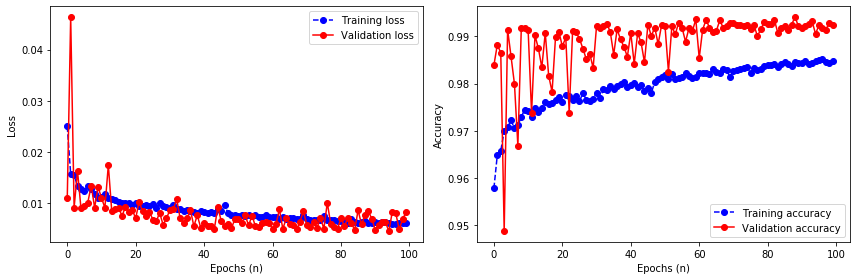

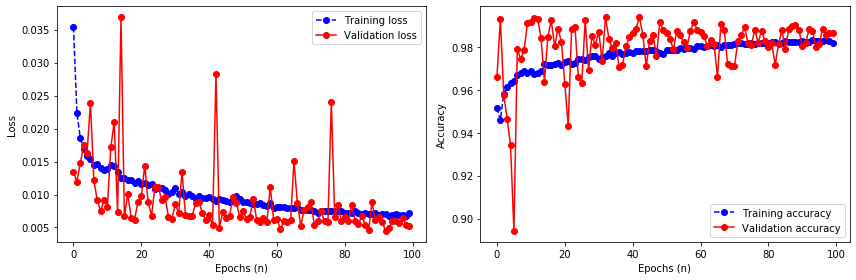

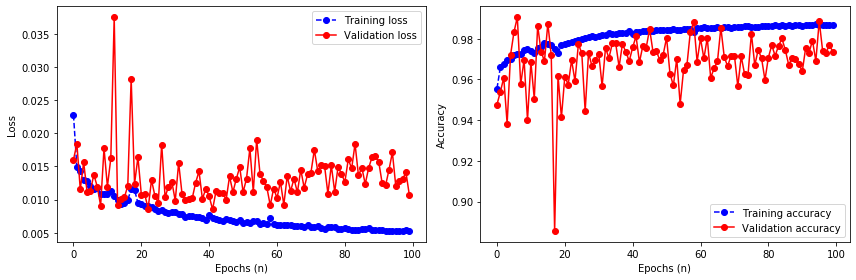

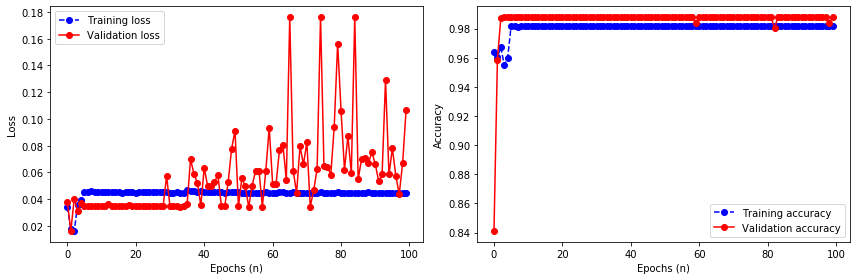

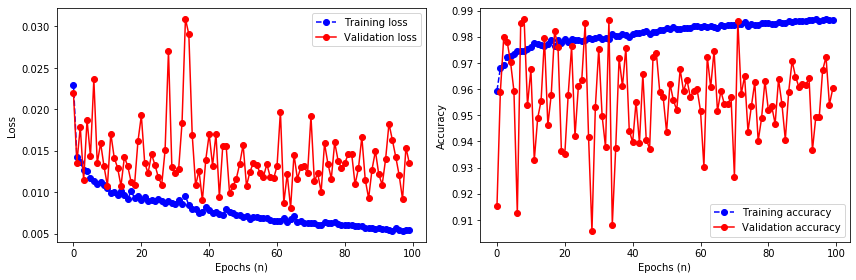

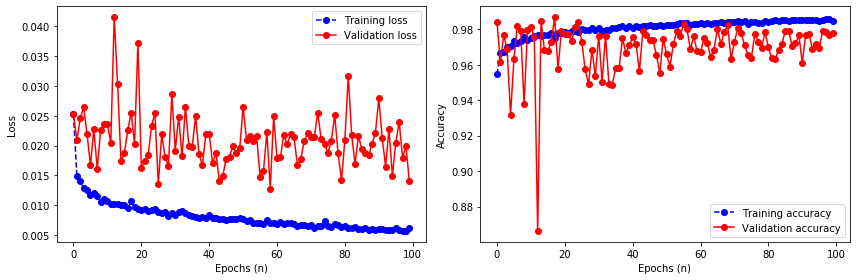

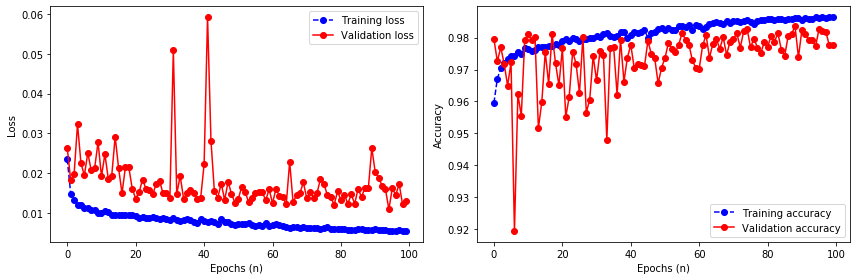

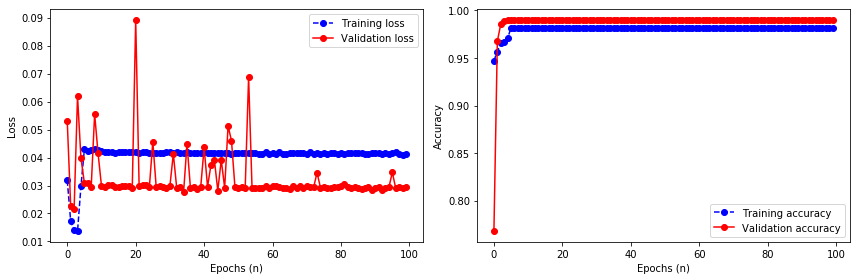

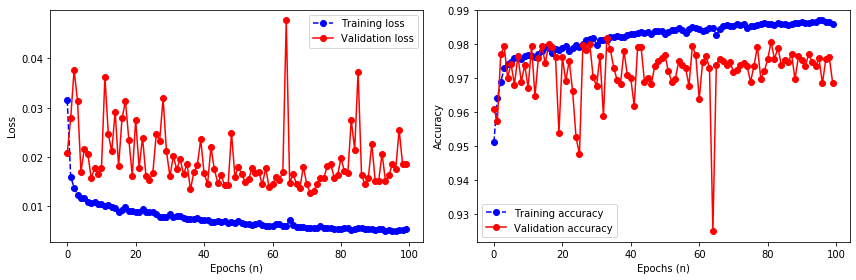

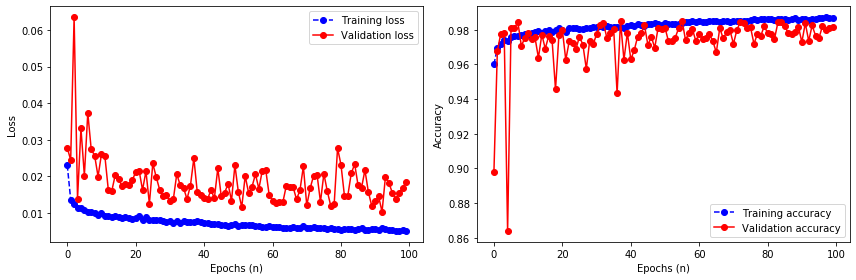

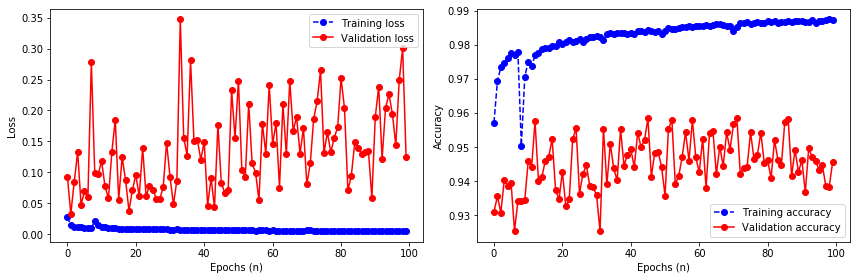

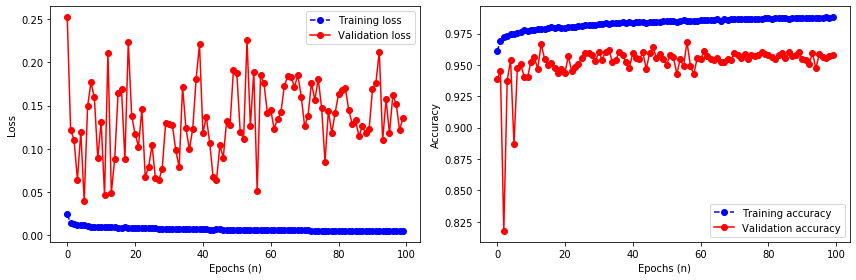

In [8]:
# Print training parameters, to archive them together with the notebook output.

time_sequence_start = datetime.datetime.now()

print("Timestamp for saved files: {}".format(save_timestamp))
print("\nTraining parameters")
print("Number of epochs:    {}".format(num_epochs))
print("Step size maximum:   {}".format(max_learning_rate))
print("Step size decay:     {}".format(learning_rate_decay))
print("Batch size:          {}".format(batch_size))
print("Regularization rate: {}".format(regularization_rate))
print("")
print("Saving validation predictions in: {}".format(val_data_fullpath))
print("Saving models in:                 {}".format(models_save_fullpath))

# ROC data will be saved in these containers

val_best_metrics    = dict()
val_fuzzy_metrics   = dict()
val_aurocs          = np.zeros(num_validation_rounds)
val_best_thresholds = np.zeros(num_validation_rounds)

# Perform validation rounds

for i in range(num_validation_rounds):
    
    # Prepare data arrays
    train_ultrasound_data = np.zeros(
        [0, ultrasound_arrays[0].shape[1], ultrasound_arrays[0].shape[2], ultrasound_arrays[0].shape[3]])
    train_segmentation_data = np.zeros(
        [0, ultrasound_arrays[0].shape[1], ultrasound_arrays[0].shape[2], ultrasound_arrays[0].shape[3]])
    
    val_ultrasound_data = np.concatenate((ultrasound_arrays[2*i], ultrasound_arrays[2*i+1]))
    val_segmentation_data = np.concatenate((segmentation_arrays[2*i], segmentation_arrays[2*i+1]))
    val_ultrasound_filename = training_ultrasound_filenames[2*i] + " " + training_ultrasound_filenames[2*i+1]
    
    for train_index in range(n_files):
        if train_index != 2*i and train_index != (2*i+1):
            train_ultrasound_data = np.concatenate((train_ultrasound_data, ultrasound_arrays[train_index]))
            train_segmentation_data = np.concatenate((train_segmentation_data, segmentation_arrays[train_index]))
    
    n_train = train_ultrasound_data.shape[0]
    n_val = val_ultrasound_data.shape[0]
    
    print("\n*** Leave-two-out round # {}".format(i))
    print("\nTraining on {} images, validating on {} images...".format(n_train, n_val))
    
    val_segmentation_data_onehot = tf.keras.utils.to_categorical(val_segmentation_data, num_classes)
    
    print("Validation ultrasound data shape:            {}".format(val_ultrasound_data.shape))
    print("Validation segmentation data shape:          {}".format(val_segmentation_data.shape))
    print("Validation segmentation data (onehot) shape: {}".format(val_segmentation_data_onehot.shape))
    
    # Create and train model
    
    model = resunet.resunet(ultrasound_size, num_classes)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
        # loss=tf.keras.losses.categorical_crossentropy,
        #loss=resunet.dice_loss,
        loss = resunet.weighted_categorical_crossentropy(class_weights),
        metrics=["accuracy", resunet.dice_coef]
    )
        
    # model.summary()
        
    training_generator = generator.UltrasoundSegmentationBatchGenerator(
        train_ultrasound_data,
        train_segmentation_data[:, :, :, 0],
        batch_size,
        (ultrasound_size, ultrasound_size),
        max_shift_factor=max_shift_factor,
        min_zoom_factor=min_zoom_factor,
        max_zoom_factor=max_zoom_factor,
        max_rotation_angle=max_rotation_angle
    )
        
    training_time_start = datetime.datetime.now()
    
    training_log = model.fit_generator(
        training_generator,
        validation_data=(val_ultrasound_data, val_segmentation_data_onehot),
        epochs=num_epochs,
        verbose=1
    )
        
    training_time_stop = datetime.datetime.now()
    
    # Pring training log
    
    print("\nMetrics at the end of training")
    print("  val_acc:       {}".format(training_log.history['val_accuracy'][-1]))
    print("  val loss:      {}".format(training_log.history['val_loss'][-1]))
    print("  val_dice:      {}".format(training_log.history['val_dice_coef'][-1]))
    print("  Training time: {}".format(training_time_stop-training_time_start))
    
    # Plot training loss and metrics
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    axes[0].plot(training_log.history['loss'], 'bo--')
    axes[0].plot(training_log.history['val_loss'], 'ro-')
    axes[0].set(xlabel='Epochs (n)', ylabel='Loss')
    axes[0].legend(['Training loss', 'Validation loss'])
    
    axes[1].plot(training_log.history['accuracy'], 'bo--')
    axes[1].plot(training_log.history['val_accuracy'], 'ro-')
    axes[1].set(xlabel='Epochs (n)', ylabel='Accuracy')
    axes[1].legend(['Training accuracy', 'Validation accuracy'])
    
    fig.tight_layout()
    
    # Predict on validation data
    
    y_pred_val  = model.predict(val_ultrasound_data)
    
    # Saving predictions for further evaluation
    
    filename_noext, extension = os.path.splitext(val_ultrasound_filename)
    val_prediction_filename = save_timestamp + "_prediction_" + filename_noext + ".npy"
    val_prediction_fullname = os.path.join(val_data_fullpath, val_prediction_filename)
    np.save(val_prediction_fullname, y_pred_val)
    
    # Archive trained model with unique filename based on notebook name and timestamp
    
    model_file_name = this_notebook_name + "_model-" + str(i) + "_" + save_timestamp + ".h5"
    model_fullname = os.path.join(models_save_fullpath, model_file_name)
    model.save(model_fullname)
    
    # Validation results
    
    vali_metrics_dicts, vali_best_threshold_index, vali_area = evaluation_metrics.compute_roc(
        roc_thresholds, y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)
    
    val_fuzzy_metrics[i] = evaluation_metrics.compute_evaluation_metrics(
        y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)
    
    val_best_metrics[i]    = vali_metrics_dicts[vali_best_threshold_index]
    val_aurocs[i]          = vali_area
    val_best_thresholds[i] = roc_thresholds[vali_best_threshold_index]
    
    # Printing total time of this validation round
    
    print("\nTotal round time:  {}".format(datetime.datetime.now() - training_time_start))
    print("")
    clear_session()


time_sequence_stop = datetime.datetime.now()

print("\nTotal training time:   {}".format(time_sequence_stop - time_sequence_start))


In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [9]:
# Arrange results in tables

metric_labels = [
    "Acc",
    "AUROC",
    "best thresh",
    "best TP",
    "best FP",
    "best recall",
    "best precis",
    "best dice",
    "fuzzy recall",
    "fuzzy precis",
    "fuzzy Fscore"
]

results_labels = []

for label in metric_labels:
    results_labels.append("Vali " + label)

results_df = pd.DataFrame(columns = results_labels)

for i in range(11):
    results_df.loc[i] = [
        val_best_metrics[i][evaluation_metrics.ACCURACY],
        val_aurocs[i],
        val_best_thresholds[i],
        val_best_metrics[i][evaluation_metrics.TRUE_POSITIVE_RATE],
        val_best_metrics[i][evaluation_metrics.FALSE_POSITIVE_RATE],
        val_best_metrics[i][evaluation_metrics.RECALL],
        val_best_metrics[i][evaluation_metrics.PRECISION],
        val_best_metrics[i][evaluation_metrics.DICE],
        val_fuzzy_metrics[i][evaluation_metrics.RECALL],
        val_fuzzy_metrics[i][evaluation_metrics.PRECISION],
        val_fuzzy_metrics[i][evaluation_metrics.FSCORE]
        
    ]

display(results_df)

print("\nAverages")

results_means_df = results_df.mean()
display(results_means_df)

,Vali Acc,Vali AUROC,Vali best thresh,Vali best TP,Vali best FP,Vali best recall,Vali best precis,Vali best dice,Vali fuzzy recall,Vali fuzzy precis,Vali fuzzy Fscore
0,0.975185,0.984223,0.002,0.983973,0.024906,0.983973,0.289059,0.446849,0.690320,0.721211,0.705427
1,0.962102,0.989606,0.020,0.984589,0.038043,0.984589,0.143079,0.249850,0.804403,0.314362,0.452059
2,0.938264,0.976175,0.020,0.971765,0.062049,0.971765,0.127822,0.225927,0.775478,0.231708,0.356805
3,0.961447,0.000000,0.001,0.000000,0.026753,0.000000,0.000000,0.000000,0.000061,0.005752,0.000121
4,0.948760,0.983386,0.250,0.945734,0.051189,0.945734,0.239088,0.381683,0.862562,0.279073,0.421708
5,0.913157,0.977654,0.040,0.951896,0.087367,0.951896,0.128423,0.226313,0.646377,0.269349,0.380247
6,0.964289,0.992361,0.100,0.979095,0.036285,0.979095,0.511106,0.671616,0.864321,0.665358,0.751900
7,0.402270,0.394764,0.200,0.986635,0.603641,0.986635,0.016264,0.032001,0.216101,0.015795,0.029438
8,0.941035,0.983489,0.100,0.940037,0.058935,0.940037,0.328845,0.487242,0.789357,0.460248,0.581464
9,0.948000,0.978230,0.020,0.950324,0.052057,0.950324,0.311259,0.468930,0.692255,0.587795,0.635763



Averages


Vali Acc             0.894342
Vali AUROC           0.829693
Vali best thresh     0.069182
Vali best TP         0.866821
Vali best FP         0.104991
Vali best recall     0.866821
Vali best precis     0.222180
Vali best dice       0.334885
Vali fuzzy recall    0.627758
Vali fuzzy precis    0.378705
Vali fuzzy Fscore    0.445767
dtype: float64

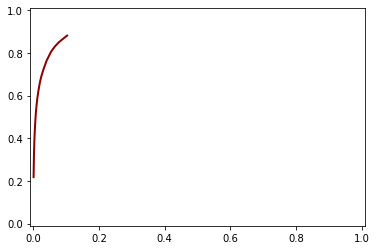

In [10]:

# Print the last ROC curve for visual verification that we catch the optimal point

n = len(roc_thresholds)

roc_x = np.zeros(n)
roc_y = np.zeros(n)

for i in range(n):
    roc_x[i] = vali_metrics_dicts[i][evaluation_metrics.FALSE_POSITIVE_RATE]
    roc_y[i] = vali_metrics_dicts[i][evaluation_metrics.SENSITIVITY]
    # print("Threshold = {0:4.2f}  False pos rate = {1:4.2f}  Sensitivity = {2:4.2f}"
    #       .format(roc_thresholds[i], roc_x[i], roc_y[i]))

    
plt.figure()
plt.ylim(-0.01, 1.01)
plt.xlim(-0.01, 1.01)
plt.plot(roc_x, roc_y, color='darkred', lw=2)

In [11]:
# Save results table

csv_filename = this_notebook_name + "_" + save_timestamp + ".csv"
csv_fullname = os.path.join(results_save_fullpath, csv_filename)
results_df.to_csv(csv_fullname)

print("Results saved to: {}".format(csv_fullname))

Results saved to: /home/justin/Desktop/BreastTumorSegmentationStudy/SavedResults/ResUNet-BreastTumorSegmentationStudy_2020-01-29_10-50-57.csv


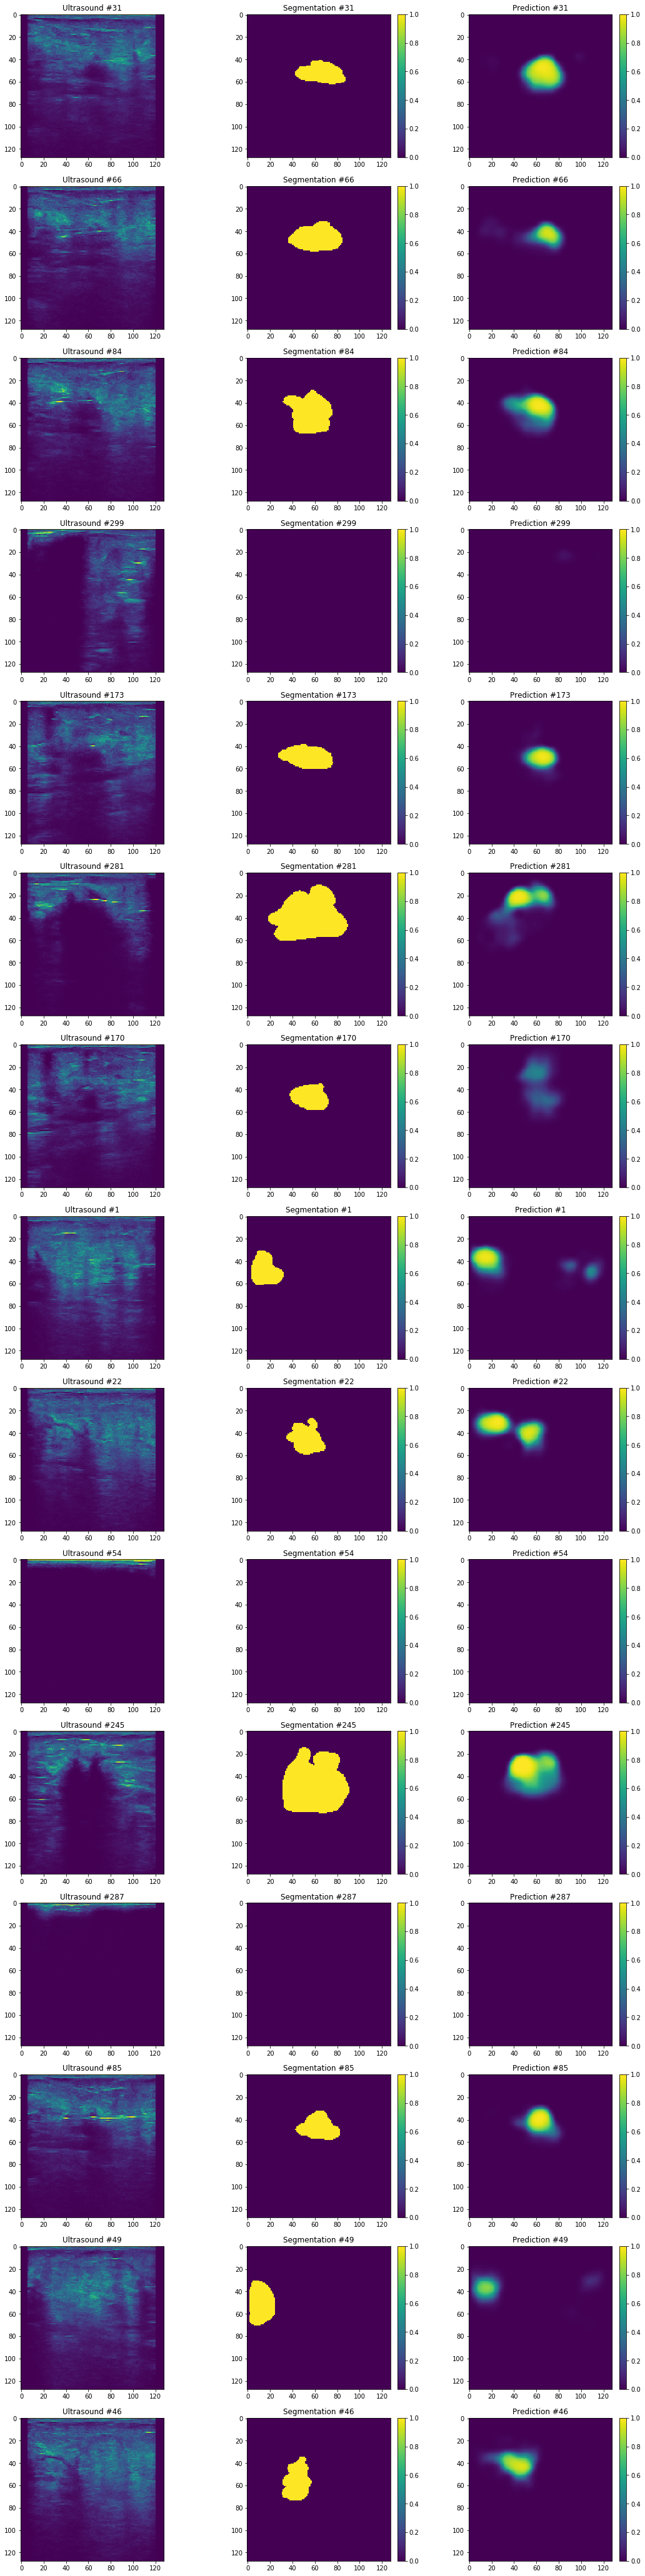

In [12]:
# Display sample results

num_vali = val_ultrasound_data.shape[0]
num_show = 15

indices = [i for i in range(num_vali)]
sample_indices = sample(indices, num_show)

# Uncomment for comparing the same images
# sample_indices = [105, 195, 391, 133, 142]

fig = plt.figure(figsize=(18, num_show*5))
for i in range(num_show):
    a0 = fig.add_subplot(num_show,3,i*3+1)
    img0 = a0.imshow(np.flipud(val_ultrasound_data[sample_indices[i], :, :, 0].astype(np.float32)))
    a0.set_title("Ultrasound #{}".format(sample_indices[i]))
    a1 = fig.add_subplot(num_show,3,i*3+2)
    img1 = a1.imshow(np.flipud(val_segmentation_data_onehot[sample_indices[i], :, :, 1]), vmin=0.0, vmax=1.0)
    a1.set_title("Segmentation #{}".format(sample_indices[i]))
    c = fig.colorbar(img1, fraction=0.046, pad=0.04)
    a2 = fig.add_subplot(num_show,3,i*3+3)
    img2 = a2.imshow(np.flipud(y_pred_val[sample_indices[i], :, :, 1]), vmin=0.0, vmax=1.0)
    a2.set_title("Prediction #{}".format(sample_indices[i]))
    c = fig.colorbar(img2, fraction=0.046, pad=0.04)

In [13]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

<IPython.core.display.Javascript object>

In [14]:

# Export HTML copy of this notebook

notebook_file_name = this_notebook_name + "_" + save_timestamp + ".html"
notebook_fullname = os.path.join(notebooks_save_fullpath, notebook_file_name)

os.system("jupyter nbconvert --to html " + this_notebook_name + " --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

Notebook saved to: /home/justin/Desktop/BreastTumorSegmentationStudy/SavedNotebooks/ResUNet-BreastTumorSegmentationStudy_2020-01-29_10-50-57.html
